In [1]:
import os
import pickle
import tqdm
import functools
import multiprocessing
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

import util_localization_psychophysics
import util_localization_psychophysics_figures
import util_spkr_word_psychophysics
import util_spkr_word_psychophysics_figures
import util

dir_fig = "figures_revision1"


In [ ]:
"""
Run all sound localization experiments.

`list_regex_dir_model` is a list of model conditions
(different phase locking limits / cochlear models).

Each directory included must contain the model evaluation
output files for each psychophysical stimulus dataset (all
model predictions, output probabilities, and stimulus data).
"""

list_regex_dir_model = [
    "models/sound_localization/sr20000_IHC3000_delayed_integration/arch??",
    "models/sound_localization/sr20000_IHC3000/arch??",
    "models/sound_localization/IHC3000_delayed_integration/arch??",
    "models/sound_localization/IHC3000/arch??",
    "models/sound_localization/IHC1000/arch??",
    "models/sound_localization/IHC0320/arch??",
    "models/sound_localization/IHC0050/arch??",
    "models/sound_localization/simplified_IHC3000_delayed_integration/arch??",
    "models/sound_localization/simplified_IHC3000/arch??",
    "models/sound_localization/simplified_IHC1000/arch??",
    "models/sound_localization/simplified_IHC0320/arch??",
    "models/sound_localization/simplified_IHC0050/arch??",
]

EXPERIMENT_DATAFRAMES = util_localization_psychophysics.run_localization_experiments(
    list_regex_dir_model,
    workers=60,
    dir_human_data="data/human/sound_localization",
    tag_ckpt="",
    func_label_to_azim_elev=util_localization_psychophysics.label_to_azim_elev,
    key_pred_prob="label_loc_int:probs_out",
    key_pred="label_loc_int:labels_pred",
    key_true="label_loc_int:labels_true",
    n_loc_classes=504,
)


In [ ]:
"""
Save sound localization experiment data to files.

A dictionary of all experiment results is saved to
a single pickle file. Individual experiment results
are also saved to separate CSV files.
"""

fn_data = "data/model/sound_localization.pkl"
with open(fn_data, "wb") as f:
    pickle.dump(EXPERIMENT_DATAFRAMES, f)
print(f"Wrote: {fn_data}")

for tag_expt in EXPERIMENT_DATAFRAMES.keys():
    fn_data_expt = fn_data.replace(".pkl", f"/{tag_expt}.csv")
    EXPERIMENT_DATAFRAMES[tag_expt].to_csv(fn_data_expt, index=False)
    print(f"Wrote: {fn_data_expt}")


In [ ]:
"""
Load all sound localization experiment data.
"""

fn_data = "data/model/sound_localization.pkl"
with open(fn_data, "rb") as f:
    EXPERIMENT_DATAFRAMES = pickle.load(f)
print(f"Loaded: {fn_data}")
for tag_expt in EXPERIMENT_DATAFRAMES.keys():
    print(f"|__ {tag_expt}")


In [ ]:
"""
Calculate human-model comparison metrics for
all sound localization experiments and save
output to a file.
"""

dict_metric_function = {
    "pearsonr": scipy.stats.pearsonr,
    "rmse": util.normalized_rmse,
}

df_results = []
for tag_expt in tqdm.tqdm(EXPERIMENT_DATAFRAMES.keys()):
    df = EXPERIMENT_DATAFRAMES[tag_expt]
    df_results_tmp = util_localization_psychophysics.compare_localization_experiment(
        df,
        tag_expt=tag_expt,
        dict_metric_function=dict_metric_function,
        bootstrap_repeats=1000,
        workers=60,
    )
    if df_results_tmp is not None:
        df_results.append(df_results_tmp)
df_results = pd.concat(df_results)

fn_metrics = "data/model/sound_localization_human_model_comparison_metrics.pkl"
df_results.to_pickle(fn_metrics)
print(f"Wrote: {fn_metrics}")


Loaded: data/model/sound_localization.pkl
Loaded: data/model/sound_localization_human_model_comparison_metrics.pkl


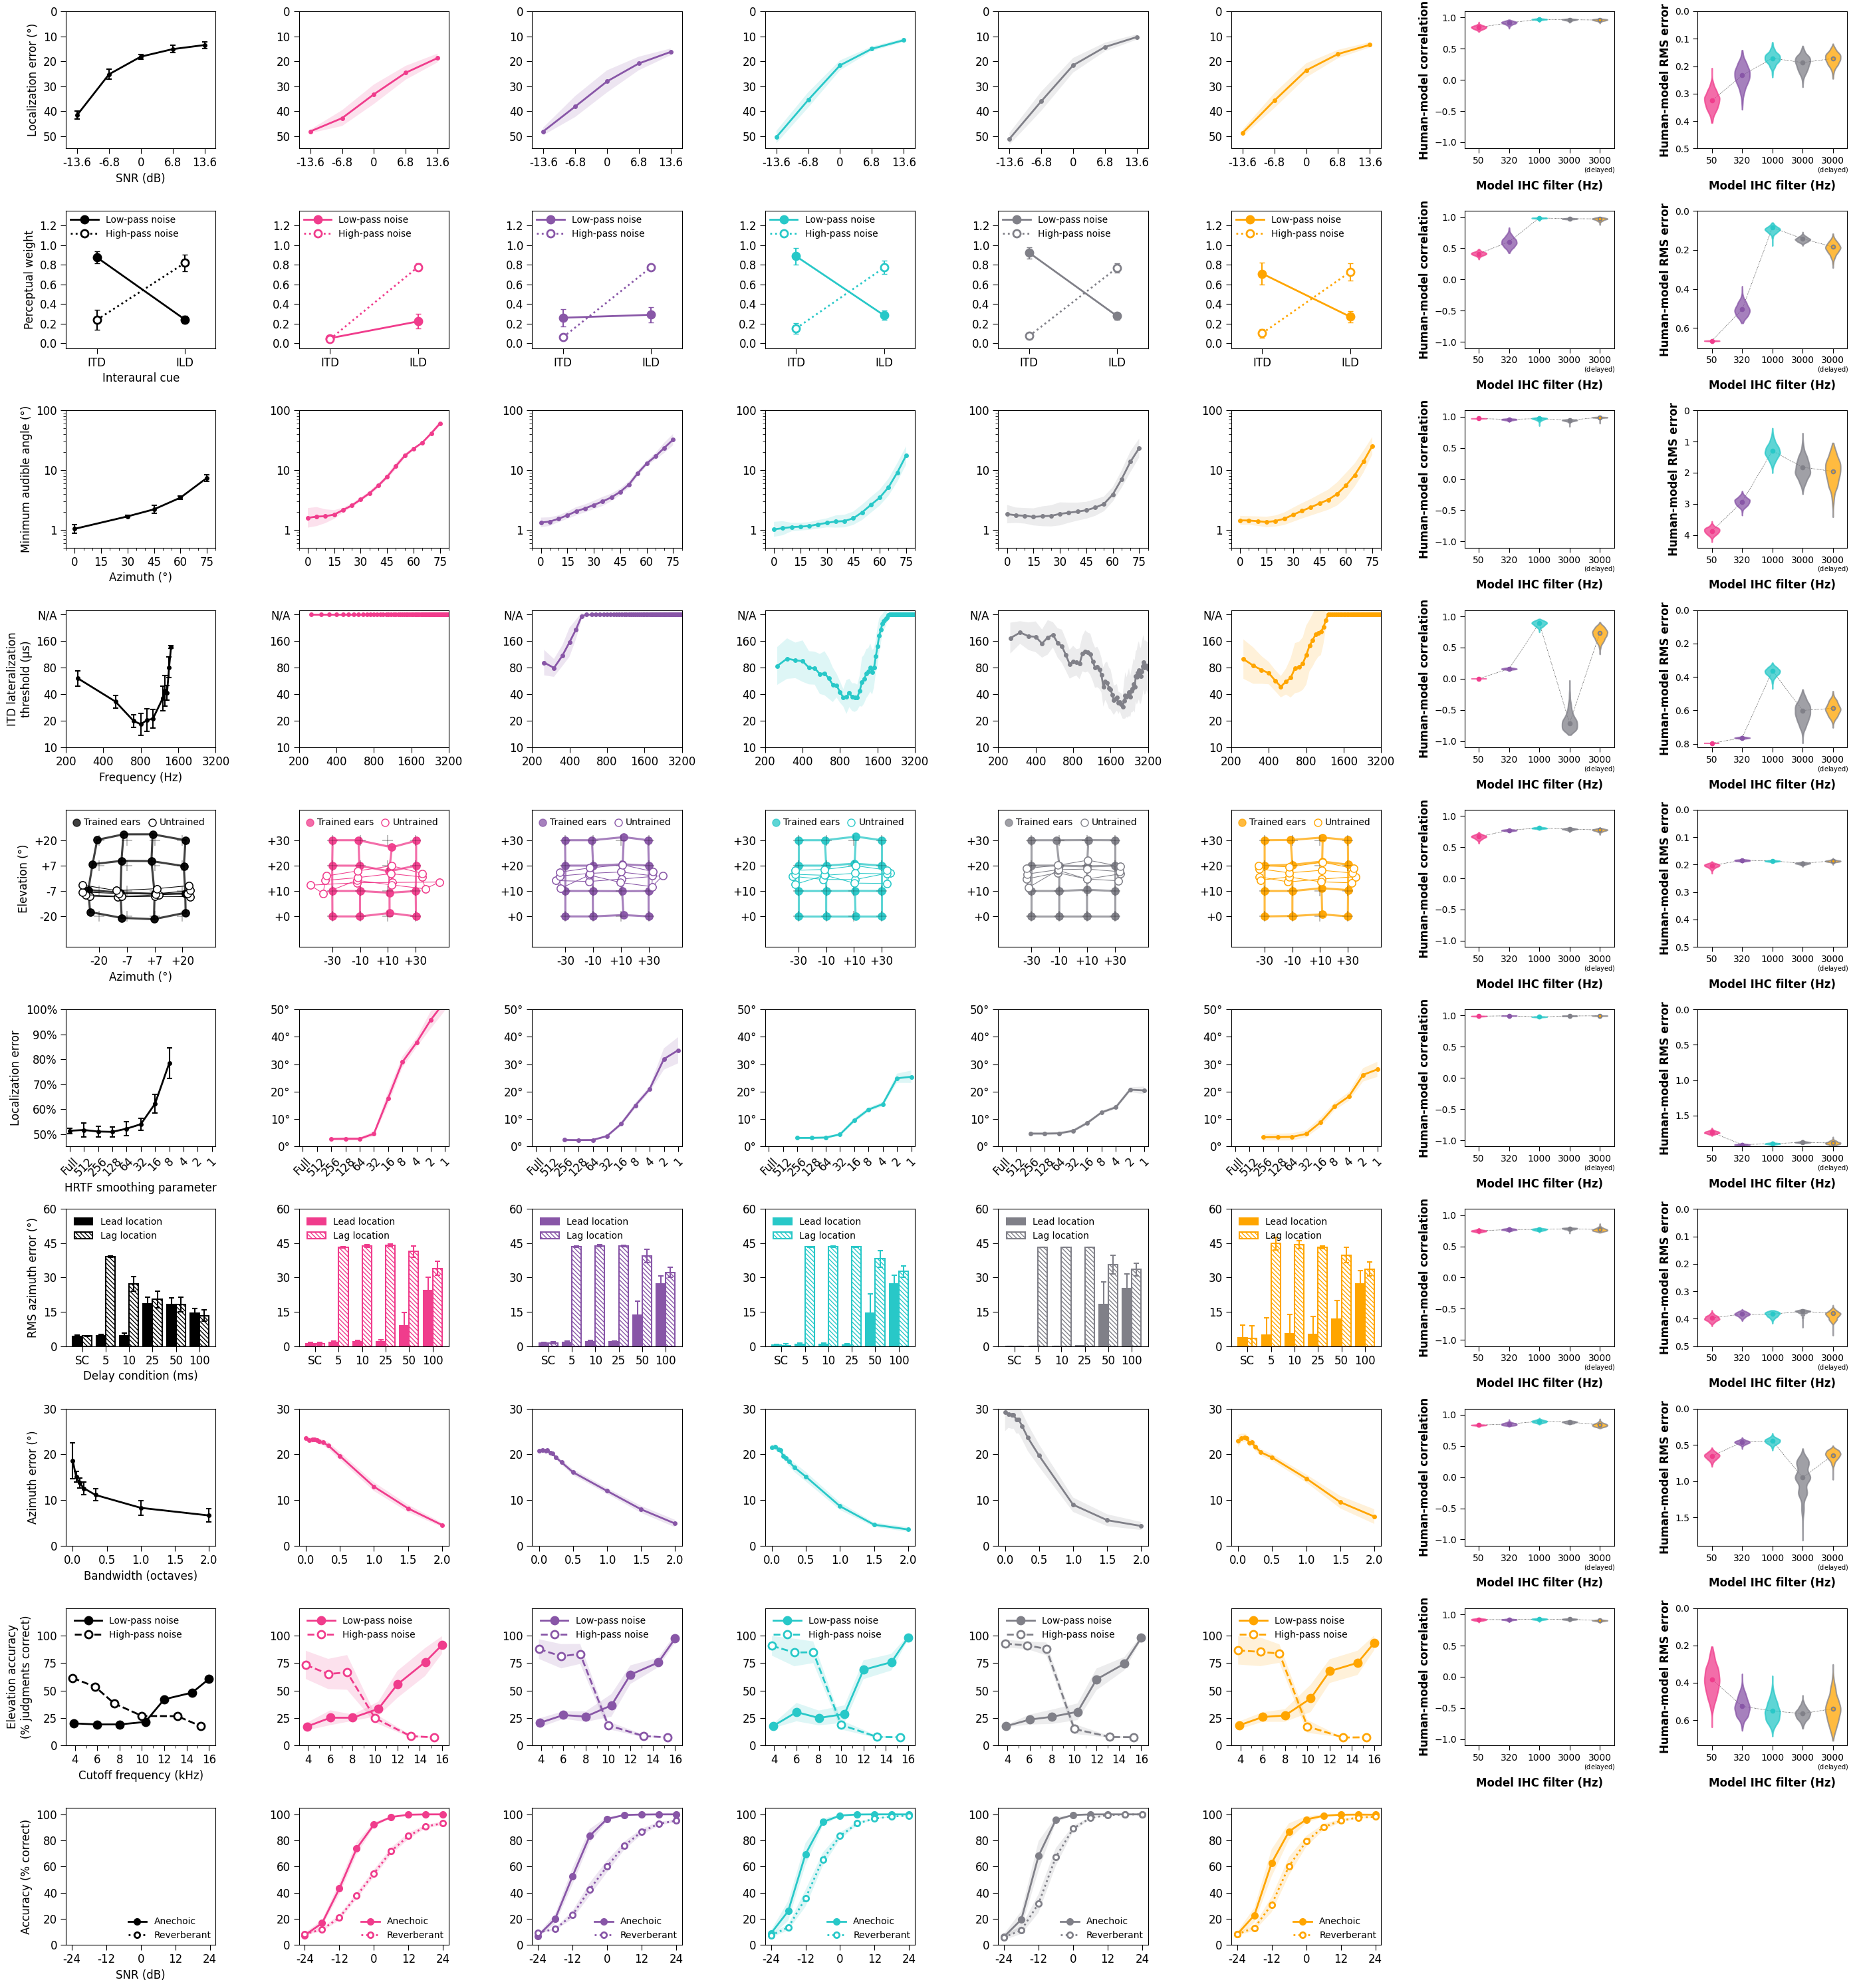

figures_revision1/results_localization_grid_simple.pdf


In [3]:
"""
Visualize all sound localization experiment results in a large grid
(including human data, model data, and human-model comparison metrics).
"""

fn_data = "data/model/sound_localization.pkl"
fn_metrics = "data/model/sound_localization_human_model_comparison_metrics.pkl"

list_tag_model = [
    # "human",
    # "models/sound_localization/IHC0050/arch??",
    # "models/sound_localization/IHC0320/arch??",
    # "models/sound_localization/IHC1000/arch??",
    # "models/sound_localization/IHC3000/arch??",
    # "models/sound_localization/IHC3000_delayed_integration/arch??",

    "human",
    "models/sound_localization/simplified_IHC0050/arch??",
    "models/sound_localization/simplified_IHC0320/arch??",
    "models/sound_localization/simplified_IHC1000/arch??",
    "models/sound_localization/simplified_IHC3000/arch??",
    "models/sound_localization/simplified_IHC3000_delayed_integration/arch??",
]

with open(fn_data, "rb") as f:
    EXPERIMENT_DATAFRAMES = pickle.load(f)
print(f"Loaded: {fn_data}")
df_comparison = pd.read_pickle(fn_metrics)
print(f"Loaded: {fn_metrics}")

map_tag_expt_to_plot_func = {
    "snr_dependency": util_localization_psychophysics_figures.make_plot_snr_dependency,
    "itd_ild_weighting": util_localization_psychophysics_figures.make_plot_itd_ild_weighting,
    "maa_azimuth": util_localization_psychophysics_figures.make_plot_maa_azimuth,
    "itd_threshold": util_localization_psychophysics_figures.make_plot_itd_threshold,
    "new_ears": util_localization_psychophysics_figures.make_plot_new_ears,
    "spectral_smoothing": util_localization_psychophysics_figures.make_plot_spectral_smoothing,
    "precedence_effect_localization": util_localization_psychophysics_figures.make_plot_precedence_effect_localization,
    "bandwidth_dependency": util_localization_psychophysics_figures.make_plot_bandwidth_dependency,
    "mp_spectral_cues": util_localization_psychophysics_figures.make_plot_mp_spectral_cues,
    "speech_in_noise_in_reverb": util_localization_psychophysics_figures.make_plot_speech_in_noise_in_reverb,
}

list_key_metric = [
    "pearsonr",
    "rmse",
]
nrows = len(map_tag_expt_to_plot_func.keys())
ncols = len(list_tag_model) + len(list_key_metric)
figsize = (3.5 * ncols, 3 * nrows)
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
ax_arr = ax_arr.reshape([nrows, ncols])
for c, tag_model in enumerate(list_tag_model):
    for r, tag_expt in enumerate(map_tag_expt_to_plot_func.keys()):
        ax = ax_arr[r, c]
        df = EXPERIMENT_DATAFRAMES[tag_expt]
        color, _ = util.get_color_and_label_from_model_tag(tag_model)
        if "delayed" in tag_model:
            color = "orange"
        map_tag_expt_to_plot_func[tag_expt](ax, df[df.tag_model == tag_model], color=color)
        if c > 0:
            ax.xaxis.label.set_color("w")
            ax.yaxis.label.set_color("w")

for r, tag_expt in enumerate(map_tag_expt_to_plot_func.keys()):
    for itr_metric, key_metric in enumerate(list_key_metric):
        c = len(list_tag_model) + itr_metric
        ax = ax_arr[r, c]
        kwargs_format_axes_update = {
            "fontsize_ticks": 10,
            "fontweight_labels": "bold",
            "str_ylabel": r"Human-model correlation" if key_metric == "pearsonr" else "Human-model RMS error",
            "str_xlabel": "Model IHC filter (Hz)",
        }
        if key_metric == "pearsonr":
            kwargs_format_axes_update["ylimits"] = [-1.1, 1.1]
            kwargs_format_axes_update["yticks"] = [-1, -0.5, 0, 0.5, 1]
        if key_metric == "rmse":
            kwargs_format_axes_update["ylimits"] = [0, None]
        if len(df_comparison[df_comparison.tag_expt == tag_expt]) > 0:
            ax = util.make_plot_comparison_metrics(
                ax,
                df=df_comparison[df_comparison.tag_expt == tag_expt],
                key_metric=key_metric,
                list_tag_model=[_ for _ in list_tag_model if "human" not in _],
                kwargs_format_axes_update=kwargs_format_axes_update)
            if not key_metric == "pearsonr":
                ax.invert_yaxis()
            ylim = list(ax.get_ylim())
            if (key_metric == "rmse") and (ylim[0] < 0.5):
                ylim[0] = 0.5
                ax.set_ylim(ylim)
        else:
            ax.set_axis_off()
plt.tight_layout()
plt.show()

# fn_fig = os.path.join(dir_fig, "results_localization_grid.pdf")
# if any("simpl" in _ for _ in list_tag_model):
#     fn_fig = fn_fig.replace(".pdf", "_simple.pdf")
# fig.savefig(fn_fig, bbox_inches="tight", pad_inches=0.05, transparent=True)
# print(fn_fig)


In [ ]:
"""
Run all word/voice recognition experiments.

`list_regex_dir_model` is a list of model conditions
(different phase locking limits / cochlear models).

Each directory included must contain the model evaluation
output files for each psychophysical stimulus dataset (all
model predictions and stimulus metadata).
"""

list_regex_dir_model = [
    "models/spkr_recognition/sr20000_IHC3000/arch0_00??",    
    "models/spkr_recognition/IHC3000/arch0_00??",
    "models/spkr_recognition/IHC1000/arch0_00??",
    "models/spkr_recognition/IHC0320/arch0_00??",
    "models/spkr_recognition/IHC0050/arch0_00??",
    "models/word_recognition/sr20000_IHC3000/arch0_00??",
    "models/word_recognition/IHC3000/arch0_00??",
    "models/word_recognition/IHC1000/arch0_00??",
    "models/word_recognition/IHC0320/arch0_00??",
    "models/word_recognition/IHC0050/arch0_00??",
    "models/spkr_word_recognition/sr20000_IHC3000/arch0_00??",
    "models/spkr_word_recognition/IHC3000/arch0_00??",
    "models/spkr_word_recognition/IHC1000/arch0_00??",
    "models/spkr_word_recognition/IHC0320/arch0_00??",
    "models/spkr_word_recognition/IHC0050/arch0_00??",
    "models/spkr_word_recognition/simplified_IHC3000/arch0_00??",
    "models/spkr_word_recognition/simplified_IHC1000/arch0_00??",
    "models/spkr_word_recognition/simplified_IHC0320/arch0_00??",
    "models/spkr_word_recognition/simplified_IHC0050/arch0_00??",
]

dict_basename_eval = {
    "pitch_altered": "EVAL_pitch_altered_v00.json",
    "kell_like": "EVAL_word_recognition_human_experiment_v00_foreground60dbspl.json",
    "speech_in_synthetic_textures": "EVAL_word_recognition_speech_in_synthetic_textures.json",
    "hopkins_moore_2009": "EVAL_hopkins_moore_2009.json",
    "kell_like_inharmonic": "EVAL_word_recognition_human_experiment_v00_inharmonic_foreground60dbspl.json",
}

EXPERIMENT_DATAFRAMES = util_spkr_word_psychophysics.run_spkr_word_experiments(
    list_regex_dir_model,
    dict_basename_eval=dict_basename_eval,
)


In [ ]:
"""
Save word/voice recognition experiment data to files.

A dictionary of all experiment results is saved to
a single pickle file. Individual experiment results
are also saved to separate CSV files.
"""

fn_data = "data/model/spkr_word_recognition.pkl"
with open(fn_data, "wb") as f:
    pickle.dump(EXPERIMENT_DATAFRAMES, f)
print(f"Wrote: {fn_data}")

for tag_expt in EXPERIMENT_DATAFRAMES.keys():
    fn_data_expt = fn_data.replace(".pkl", f"/{tag_expt}.csv")
    EXPERIMENT_DATAFRAMES[tag_expt].to_csv(fn_data_expt, index=False)
    print(f"Wrote: {fn_data_expt}")


In [ ]:
"""
Load all word/voice recognition experiment data.
"""

fn_data = "data/model/spkr_word_recognition.pkl"
with open(fn_data, "rb") as f:
    EXPERIMENT_DATAFRAMES = pickle.load(f)
print(f"Loaded: {fn_data}")
for tag_expt in EXPERIMENT_DATAFRAMES.keys():
    print(f"|__ {tag_expt}")


In [ ]:
"""
Calculate human-model comparison metrics for
all word/voice recognition experiments and save
output to a file.
"""

dict_metric_function = {
    "pearsonr": scipy.stats.pearsonr,
    "rmse": util.normalized_rmse,
}

experiment_to_compfunc_map = {
    "kell_like_word": functools.partial(
        util_spkr_word_psychophysics.compare_word_recognition_kell_like,
        restrict_conditions=[0, 1, 2, 3]),
    "speech_in_synthetic_textures": functools.partial(
        util_spkr_word_psychophysics.compare_word_recognition_speech_in_synthetic_textures),
    "pitch_altered_spkr_word": functools.partial(
        util_spkr_word_psychophysics.compare_recognition_pitch_altered, key_task=["spkr", "word"]),
    "pitch_altered_word": functools.partial(
        util_spkr_word_psychophysics.compare_recognition_pitch_altered, key_task="word"),
    "pitch_altered_spkr": functools.partial(
        util_spkr_word_psychophysics.compare_recognition_pitch_altered, key_task="spkr"),
    "hopkins_moore_2009_word": functools.partial(
        util_spkr_word_psychophysics.compare_word_recognition_hopkins_moore_2009),
}

def func_to_parallelize(tag_expt):
    compfunc = experiment_to_compfunc_map[tag_expt]
    tag_expt_for_dataframe = tag_expt
    for suffix in ["_spkr", "_word"]:
        tag_expt_for_dataframe = tag_expt_for_dataframe.replace(suffix, "")
    df = EXPERIMENT_DATAFRAMES[tag_expt_for_dataframe]
    df_results = None
    for metric_key, metric_function in dict_metric_function.items():
        df_results_tmp = compfunc(
            df,
            bootstrap_repeats=1000,
            metric_function=metric_function)
        df_results_tmp = df_results_tmp.rename(columns={
            "metric": metric_key,
            "list_metric": f"list_{metric_key}",
            "bootstrap_list_metric": f"bootstrap_list_{metric_key}",
        })
        df_results_tmp["tag_expt"] = tag_expt
        if df_results is None:
            df_results = df_results_tmp
        else:
            df_results = df_results.merge(df_results_tmp, on=["tag_expt", "tag_model"])
    return df_results


with multiprocessing.Pool(60) as pool:
    list_df_results = pool.map(func_to_parallelize, list(experiment_to_compfunc_map.keys()))
df_results = pd.concat(list_df_results)

# Set metrics to NaN for rows where human data is unavailable (all zeros give undefined pearsonr)
IDX = df_results["pearsonr"].isna()
df_results.loc[IDX, "rmse"] = df_results.loc[IDX, "pearsonr"]
df_results.loc[IDX, "list_rmse"] = df_results.loc[IDX, "list_pearsonr"]
df_results.loc[IDX, "bootstrap_list_rmse"] = df_results.loc[IDX, "bootstrap_list_pearsonr"]

fn_metrics = "data/model/spkr_word_recognition_human_model_comparison_metrics.pkl"
df_results.to_pickle(fn_metrics)
print(f"Wrote: {fn_metrics}")


Loaded: data/model/spkr_word_recognition.pkl
Loaded: data/model/spkr_word_recognition_human_model_comparison_metrics.pkl


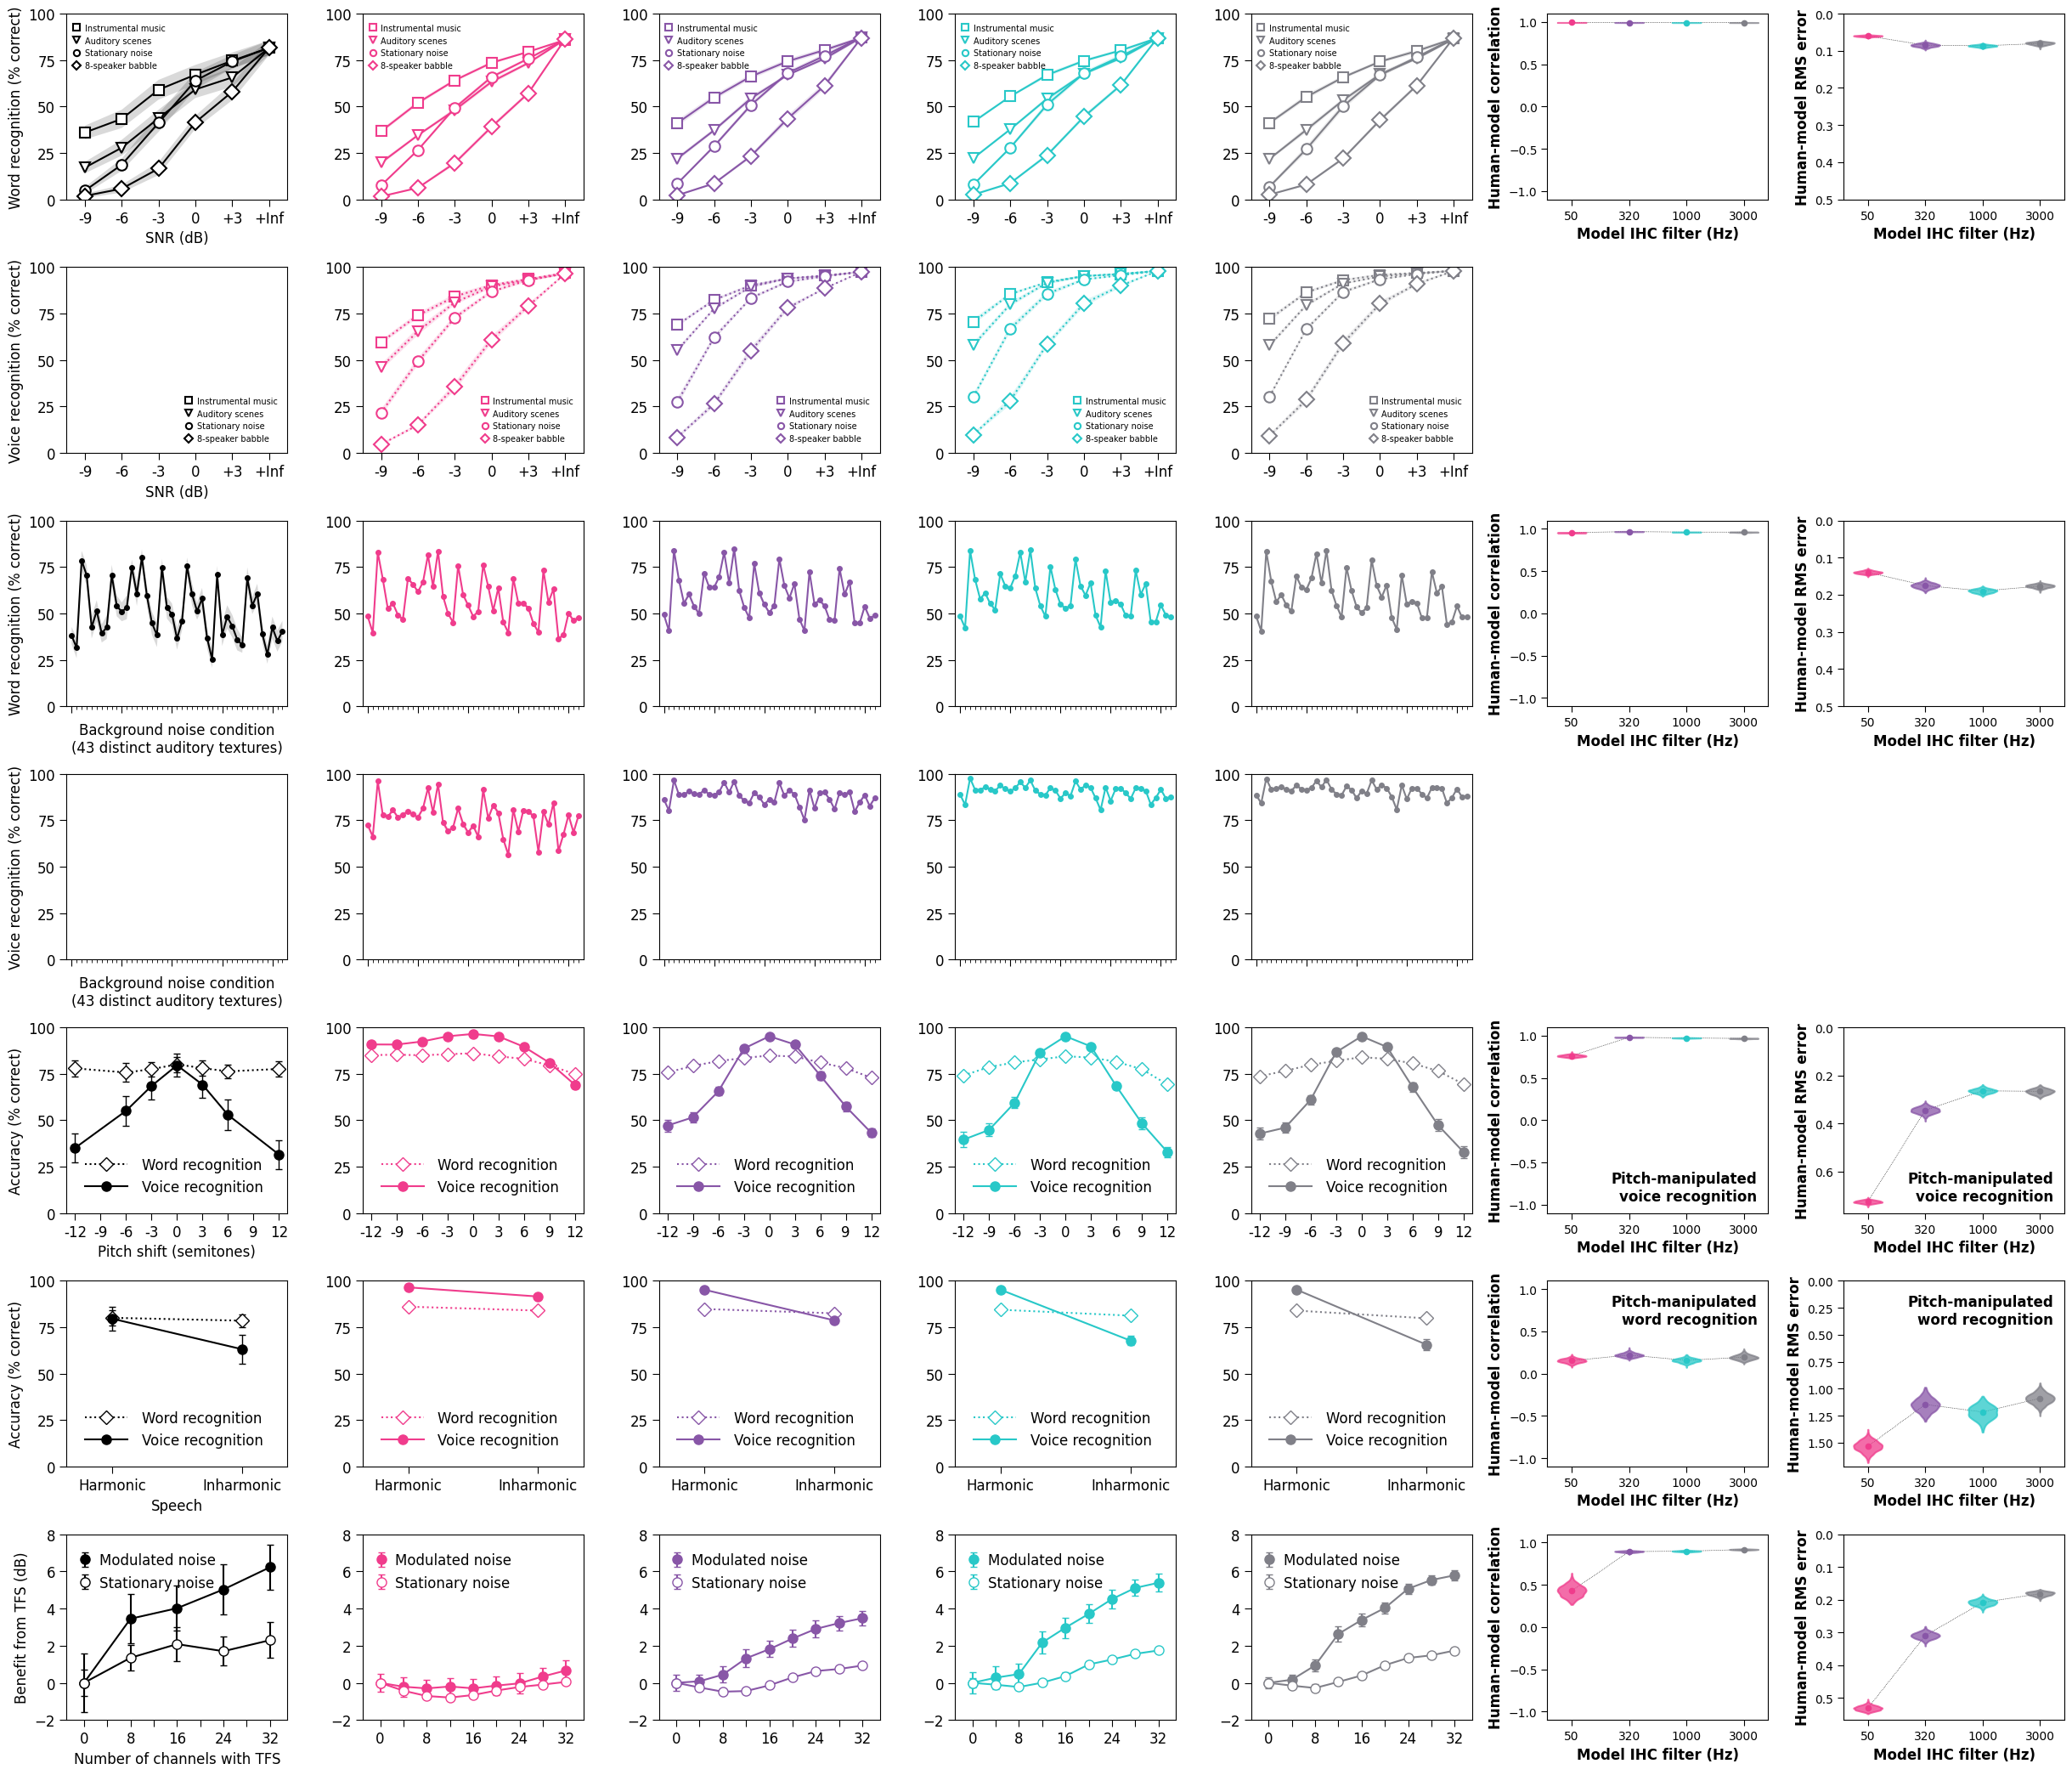

figures_revision1/results_spkr_word_grid.pdf


In [9]:
"""
Visualize all word/voice recognition experiment results in a large grid
(including human data, model data, and human-model comparison metrics).
"""

fn_data = "data/model/spkr_word_recognition.pkl"
fn_metrics = "data/model/spkr_word_recognition_human_model_comparison_metrics.pkl"

list_tag_model = [
    "human",
    "models/spkr_word_recognition/IHC0050/arch0_00??",
    "models/spkr_word_recognition/IHC0320/arch0_00??",
    "models/spkr_word_recognition/IHC1000/arch0_00??",
    "models/spkr_word_recognition/IHC3000/arch0_00??",

    # "human",
    # "models/spkr_word_recognition/simplified_IHC0050/arch0_00??",
    # "models/spkr_word_recognition/simplified_IHC0320/arch0_00??",
    # "models/spkr_word_recognition/simplified_IHC1000/arch0_00??",
    # "models/spkr_word_recognition/simplified_IHC3000/arch0_00??",
]
SINGLE_TASK_MODELS = 0 # Set to 1 to automatically replace joint word/voice recognition models with single-task variants

with open(fn_data, "rb") as f:
    EXPERIMENT_DATAFRAMES = pickle.load(f)
print(f"Loaded: {fn_data}")
df_comparison = pd.read_pickle(fn_metrics)
print(f"Loaded: {fn_metrics}")

map_tag_expt_to_plot_func = {
    "kell_like_word": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_kell_like_recognition,
        key_task="word",
        fontsize_legend=7,
        restrict_background_condition=[2, 0, 3, 1]),
    "kell_like_spkr": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_kell_like_recognition,
        key_task="spkr",
        fontsize_legend=7,
        restrict_background_condition=[2, 0, 3, 1],
        kwargs_plot_update={"ls": ":"}),
    "speech_in_synthetic_textures_word": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_speech_in_synthetic_textures,
        key_task="word"),
    "speech_in_synthetic_textures_spkr": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_speech_in_synthetic_textures,
        key_task="spkr"),
    "pitch_shifted": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_pitch_shifted_recognition,
        key_task=["word", "spkr"]),
    "pitch_condition": functools.partial(
        util_spkr_word_psychophysics_figures.make_plot_pitch_condition_recognition,
        key_task=["word", "spkr"]),
    "hopkins_moore_2009_word": util_spkr_word_psychophysics_figures.make_plot_hopkins_moore_2009_tfs_benefit,
}

list_key_metric = [
    "pearsonr",
    "rmse",
]
nrows = len(map_tag_expt_to_plot_func.keys())
ncols = len(list_tag_model) + len(list_key_metric)
figsize = (3.5 * ncols, 3 * nrows)
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
ax_arr = ax_arr.reshape([nrows, ncols])
for r, tag_expt in enumerate(map_tag_expt_to_plot_func.keys()):
    tag_expt_for_dataframe = tag_expt
    if "pitch" in tag_expt:
        tag_expt_for_dataframe = "pitch_altered"
    for suffix in ["_spkr", "_word", "_dip_listening"]:
        tag_expt_for_dataframe = tag_expt_for_dataframe.replace(suffix, "")
    for c, tag_model in enumerate(list_tag_model):
        color, _ = util.get_color_and_label_from_model_tag(tag_model)
        ax = ax_arr[r, c]
        df = EXPERIMENT_DATAFRAMES[tag_expt_for_dataframe]
        if (not tag_model == "human") and (SINGLE_TASK_MODELS):
            if "spkr" in tag_expt:
                df = df[df.tag_model == tag_model.replace("spkr_word_recognition", "spkr_recognition")]
                map_tag_expt_to_plot_func[tag_expt](ax, df, color=color, key_task="spkr")
            if "word" in tag_expt:
                df = df[df.tag_model == tag_model.replace("spkr_word_recognition", "word_recognition")]
                map_tag_expt_to_plot_func[tag_expt](ax, df, color=color, key_task="word")
            if (not "spkr" in tag_expt) and (not "word" in tag_expt):
                df_merged = df[df.tag_model == tag_model.replace("spkr_word_recognition", "spkr_recognition")].copy()
                df_word = df[df.tag_model == tag_model.replace("spkr_word_recognition", "word_recognition")].copy()
                for column in df_word.columns:
                    if "word" in column:
                        df_merged.loc[:, column] = df_word[column].values
                map_tag_expt_to_plot_func[tag_expt](ax, df_merged, color=color)
        else:
            df = df[df.tag_model == tag_model]
            map_tag_expt_to_plot_func[tag_expt](ax, df, color=color)
        if c > 0:
            ax.xaxis.label.set_color("w")
            ax.yaxis.label.set_color("w")

for r, tag_expt in enumerate(map_tag_expt_to_plot_func.keys()):
    for itr_metric, key_metric in enumerate(list_key_metric):
        c = len(list_tag_model) + itr_metric
        ax = ax_arr[r, c]
        list_tag_model_for_make_plot_comparison_metrics = [_ for _ in list_tag_model if "human" not in _]
        tag_expt_for_dataframe = tag_expt
        if "pitch_shifted" in tag_expt:
            tag_expt_for_dataframe = "pitch_altered_spkr"
        elif "pitch_condition" in tag_expt:
            tag_expt_for_dataframe = "pitch_altered_word"
        elif "speech_in_synthetic_textures_word" in tag_expt:
            tag_expt_for_dataframe = "speech_in_synthetic_textures"
        if SINGLE_TASK_MODELS:
            list_tag_model_for_make_plot_comparison_metrics = [
                _.replace(
                    "spkr_word_recognition",
                    "spkr_recognition" if "spkr" in tag_expt_for_dataframe else "word_recognition",
                )
                for _ in list_tag_model_for_make_plot_comparison_metrics
            ]
        kwargs_format_axes_update = {
            "fontsize_ticks": 10,
            "fontweight_labels": "bold",
            "str_ylabel": r"Human-model correlation" if key_metric == "pearsonr" else "Human-model RMS error",
            "str_xlabel": "Model IHC filter (Hz)",
        }
        if key_metric == "pearsonr":
            kwargs_format_axes_update["ylimits"] = [-1.1, 1.1]
            kwargs_format_axes_update["yticks"] = [-1, -0.5, 0, 0.5, 1]
        if key_metric == "rmse":
            kwargs_format_axes_update["ylimits"] = [0, None]
        if len(df_comparison[df_comparison.tag_expt == tag_expt_for_dataframe]) > 0:
            ax = util.make_plot_comparison_metrics(
                ax,
                df=df_comparison[df_comparison.tag_expt == tag_expt_for_dataframe],
                key_metric=key_metric,
                list_tag_model=list_tag_model_for_make_plot_comparison_metrics,
                kwargs_format_axes_update=kwargs_format_axes_update)
            if not key_metric == "pearsonr":
                ax.invert_yaxis()
            kwargs_text = {"ha": "right", "va": "bottom", "transform": ax.transAxes, "fontsize":12, "fontweight": "bold"}
            if tag_expt_for_dataframe == "pitch_altered_word":
                ax.text(0.95, 0.75, "Pitch-manipulated\nword recognition", **kwargs_text)
            if tag_expt_for_dataframe == "pitch_altered_spkr":
                ax.text(0.95, 0.05, "Pitch-manipulated\nvoice recognition", **kwargs_text)
            ylim = list(ax.get_ylim())
            if (key_metric == "rmse") and (ylim[0] < 0.5):
                ylim[0] = 0.5
                ax.set_ylim(ylim)
        else:
            ax.set_axis_off()
plt.tight_layout()
plt.show()

# fn_fig = os.path.join(dir_fig, "results_spkr_word_grid.pdf")
# if any("simpl" in _ for _ in list_tag_model):
#     fn_fig = fn_fig.replace(".pdf", "_simple.pdf")
# if SINGLE_TASK_MODELS:
#     fn_fig = fn_fig.replace(".pdf", "_single_task_models.pdf")
# fig.savefig(fn_fig, bbox_inches="tight", pad_inches=0.05, transparent=True)
# print(fn_fig)
